## Momentum factor

In [1]:
import os
import pandas as pd
import numpy as np
from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns
from zipline.api import (attach_pipeline, calendars, pipeline_output, date_rules, time_rules,
set_commission, set_slippage, record, order_target_percent, get_open_orders, get_datetime, schedule_function)
import pandas_datareader as pdr

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
from zipline.data.bundles.core import load
os.environ["QUANDL_API_KEY"] = "yFrqjBUBaLV_khbkKfCs"
bundle_data = load("quandl", os.environ, None)

In [4]:
N_LONGS = N_SHORTS = 50

In [5]:
class MomentumFactor(CustomFactor):
    inputs = [USEquityPricing.close, Returns(window_length=126)]
    window_length = 252
    def compute(self, today, assets, out, prices, returns):
        out[:] = ((prices[-21] -prices[-252] / prices[-252] - (prices[-1] - prices [-21]) / prices[-21])
                  / np.nanstd(returns, axis=0))

In [6]:
def make_pipeline():
    momentum = MomentumFactor()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={"factor": momentum,
                             "longs": momentum.top(N_LONGS),
                             "shorts": momentum.bottom(N_SHORTS),
                             "ranking": momentum.rank(),}, screen=dollar_volume.top(100))  

In [7]:
def before_trading_start(context, data):
    context.factor_data = pipeline_output("factor_pipeline")

In [8]:
def initialize(context):
    attach_pipeline(make_pipeline(),
                    "factor_pipeline")
    schedule_function(rebalance, 
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)

In [9]:
def rebalance(context, data):
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)
    assets = factor_data.index
    record(prices=data.current(assets, "price"))
    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))
    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)

In [10]:
def exec_trades(data, assets, target_percent):
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

In [11]:
def analyze(context, perf):
    perf.portfolio_value.plot()

In [12]:
start = pd.Timestamp("2016")
end = pd.Timestamp("2018")

In [13]:
sp500 = pdr.DataReader("SP500", "fred", start, end).SP500
benchmark_returns = sp500.pct_change()

In [14]:
perf = run_algorithm(start=start,
                     end=end,
                     initialize=initialize,
                     before_trading_start=before_trading_start,
                     capital_base=100_000,
                     benchmark_returns=benchmark_returns,
                     bundle="quandl")

In [15]:
display(perf.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2016-01-04 21:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              503 non-null    datetime64[ns, UTC]
 1   period_close             503 non-null    datetime64[ns, UTC]
 2   starting_value           503 non-null    float64            
 3   ending_value             503 non-null    float64            
 4   starting_cash            503 non-null    float64            
 5   ending_cash              503 non-null    float64            
 6   portfolio_value          503 non-null    float64            
 7   longs_count              503 non-null    int64              
 8   shorts_count             503 non-null    int64              
 9   long_value               503 non-null    float64            
 10  short_value              503 non-null    float64 

None

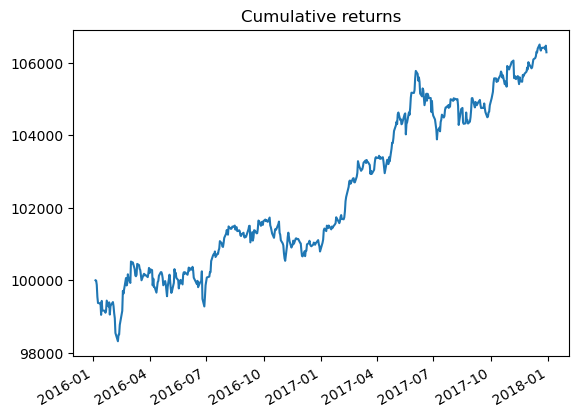

In [16]:
perf.portfolio_value.plot(title="Cumulative returns");

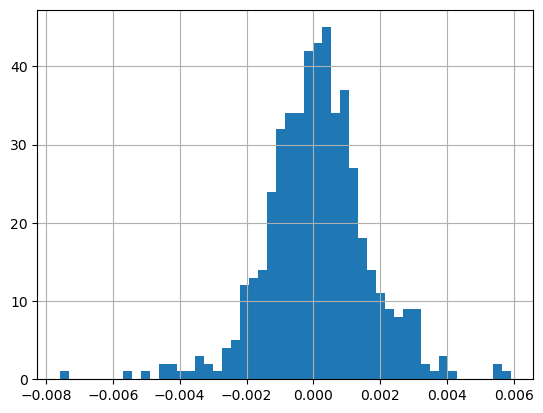

In [17]:
perf.returns.hist(bins=50);

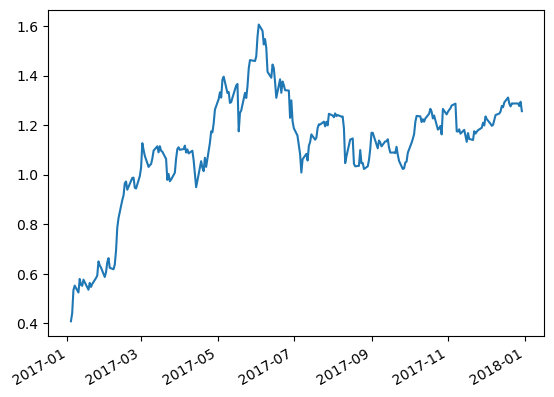

In [18]:
perf.sharpe.iloc[252:].plot();

## Mean reversion

In [19]:
import numpy as np
import pandas as pd
import pandas_datareader as web
from IPython.display import Markdown, display
from zipline import run_algorithm
from zipline.api import (attach_pipeline, calendars, date_rules, get_datetime, get_open_orders, 
order_target_percent, pipeline_output, record, schedule_function, set_commission, set_slippage, time_rules)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns

In [20]:
N_LONGS = N_SHORTS = 50
MONTH = 21
YEAR = 12 * MONTH

In [21]:
class MeanReversion(CustomFactor):
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR
    
    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())

In [22]:
def make_pipeline():
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={
        "longs": mean_reversion.bottom(N_LONGS),
        "shorts": mean_reversion.top(N_SHORTS),
        "ranking": mean_reversion.rank(ascending=False)}, screen=dollar_volume.top(100))    

In [23]:
def before_trading_start(context, data):
    context.factor_data = pipeline_output("factor_pipeline")

In [24]:
def initialize(context):
    attach_pipeline(make_pipeline(), "factor_pipeline")
    schedule_function(rebalance, date_rules.week_start(), time_rules.market_open(), calendar=calendars.US_EQUITIES)
    set_commission(us_equities=commission.PerShare(cost=0.00075, min_trade_cost=0.01))
    set_slippage(us_equities=slippage.VolumeShareSlippage(volume_limit=0.0025, price_impact=0.01))

In [25]:
def rebalance(context, data):
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, "price"))

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))
    print(f"{get_datetime().date()} | Longs {len(longs)} | Shorts {len(shorts)} | {context.portfolio.portfolio_value}")

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)   

In [26]:
def exec_trades(data, assets, target_percent):
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

In [27]:
def analyze(context, perf):
    perf.portfolio_value.plot()

In [28]:
start = pd.Timestamp("2016")
end = pd.Timestamp("2018")

In [29]:
sp500 = pdr.DataReader("SP500", "fred", start, end).SP500
benchmark_returns = sp500.pct_change()

2016-01-04 | Longs 0 | Shorts 1 | 100000.0
2016-01-11 | Longs 0 | Shorts 1 | 99993.16349999886
2016-01-19 | Longs 2 | Shorts 1 | 100021.36374999832
2016-01-25 | Longs 2 | Shorts 2 | 100047.47224999769
2016-02-01 | Longs 3 | Shorts 3 | 99889.9749999967
2016-02-08 | Longs 2 | Shorts 2 | 99616.54649999554
2016-02-16 | Longs 2 | Shorts 0 | 99849.90549999391
2016-02-22 | Longs 1 | Shorts 0 | 100195.42449999285
2016-02-29 | Longs 1 | Shorts 0 | 100155.76424999181
2016-03-07 | Longs 2 | Shorts 1 | 100114.18424999181
2016-03-14 | Longs 0 | Shorts 0 | 100304.28374999072
2016-03-21 | Longs 1 | Shorts 2 | 99210.60974998782
2016-03-28 | Longs 1 | Shorts 0 | 99355.18649998584
2016-04-04 | Longs 1 | Shorts 0 | 99108.98424998432
2016-04-11 | Longs 2 | Shorts 1 | 99483.63424998433
2016-04-18 | Longs 2 | Shorts 0 | 99556.3877499843
2016-04-25 | Longs 2 | Shorts 0 | 99573.0884999835
2016-05-02 | Longs 4 | Shorts 0 | 99557.5844999825
2016-05-09 | Longs 3 | Shorts 1 | 99399.40899998133
2016-05-16 | Longs 

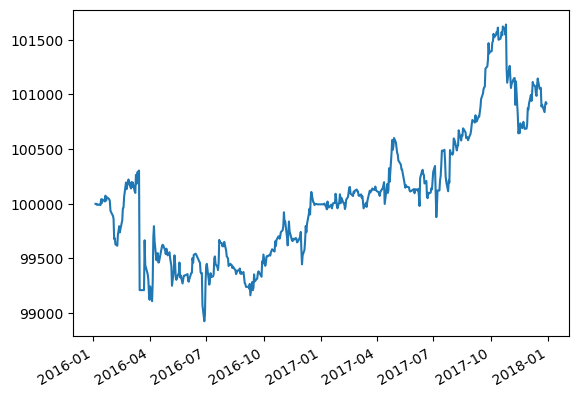

In [30]:
perf = run_algorithm(start=start,
                     end=end,
                     initialize=initialize,
                     analyze=analyze,
                     benchmark_returns=benchmark_returns,
                     before_trading_start=before_trading_start,
                     capital_base=100_000,
                     bundle="quandl")
perf.to_pickle("mean_reversion.pickle")

In [31]:
#p = make_pipeline()
# p.show_graph()

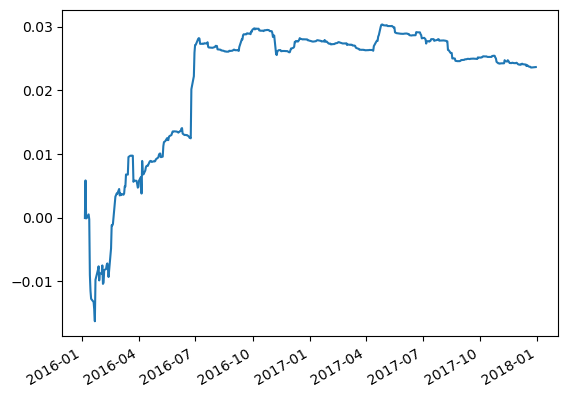

In [32]:
perf.beta.plot();

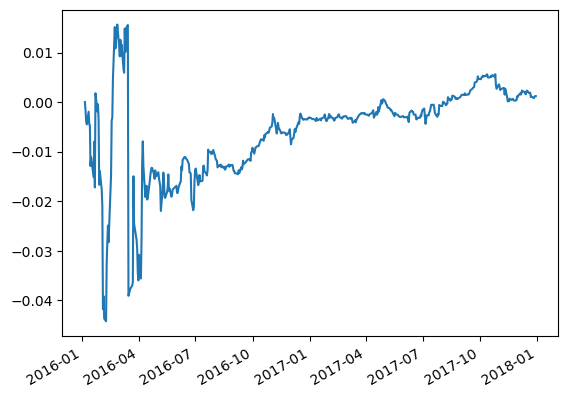

In [33]:
perf.alpha.plot();